In [112]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()


In [113]:
df = spark.read.csv("data/Advertising.csv",inferSchema=True,header=True)
df.show(10)

+------+-----+-----+---------+-----+
|number|   tv|radio|newspaper|sales|
+------+-----+-----+---------+-----+
|     1|230.1| 37.8|     69.2| 22.1|
|     2| 44.5| 39.3|     45.1| 10.4|
|     3| 17.2| 45.9|     69.3|  9.3|
|     4|151.5| 41.3|     58.5| 18.5|
|     5|180.8| 10.8|     58.4| 12.9|
|     6|  8.7| 48.9|     75.0|  7.2|
|     7| 57.5| 32.8|     23.5| 11.8|
|     8|120.2| 19.6|     11.6| 13.2|
|     9|  8.6|  2.1|      1.0|  4.8|
|    10|199.8|  2.6|     21.2| 10.6|
+------+-----+-----+---------+-----+
only showing top 10 rows



In [114]:
df.printSchema()

root
 |-- number: integer (nullable = true)
 |-- tv: double (nullable = true)
 |-- radio: double (nullable = true)
 |-- newspaper: double (nullable = true)
 |-- sales: double (nullable = true)



In [115]:
df.columns

['number', 'tv', 'radio', 'newspaper', 'sales']

In [116]:
assembler=VectorAssembler(inputCols=['tv',
 'radio',
 'newspaper'],outputCol='features')
output=assembler.transform(df)
output.select('features','sales').show(5)

+-----------------+-----+
|         features|sales|
+-----------------+-----+
|[230.1,37.8,69.2]| 22.1|
| [44.5,39.3,45.1]| 10.4|
| [17.2,45.9,69.3]|  9.3|
|[151.5,41.3,58.5]| 18.5|
|[180.8,10.8,58.4]| 12.9|
+-----------------+-----+
only showing top 5 rows



In [117]:
#final data consist of features and label which is crew.
final_data=output.select('features','sales')
#splitting data into train and test
train_data,test_data=final_data.randomSplit([0.7,0.3])
train_data.describe().show()

+-------+-----------------+
|summary|            sales|
+-------+-----------------+
|  count|              136|
|   mean|14.06691176470589|
| stddev|5.332472918749225|
|    min|              3.2|
|    max|             27.0|
+-------+-----------------+



In [118]:
test_data.describe().show()


+-------+------------------+
|summary|             sales|
+-------+------------------+
|  count|                64|
|   mean|13.928125000000001|
| stddev| 5.004044990789078|
|    min|               1.6|
|    max|              25.5|
+-------+------------------+



In [119]:
#import LinearRegression library
from pyspark.ml.regression import LinearRegression
#creating an object of class LinearRegression
#object takes features and label as input arguments
ship_lr=LinearRegression(featuresCol='features',labelCol='sales')
#pass train_data to train model
trained_sales_model=ship_lr.fit(train_data)
#evaluating model trained for Rsquared error
sales_results=trained_sales_model.evaluate(train_data)

print('Rsquared Error :',sales_results.r2)
print('intercept :',trained_sales_model.intercept)
print('coefficients :',trained_sales_model.coefficients)

Rsquared Error : 0.92143565550005
intercept : 3.345346965613256
coefficients : [0.04190956017193408,0.20658375198180065,-0.0018960547861644847]


# R2 value shows accuracy of model is 90%
#model accuracy is very good and can be use for predictive analysis

In [120]:
unlabeled_data=test_data.select('features')
unlabeled_data.show(5)

+---------------+
|       features|
+---------------+
| [0.7,39.6,8.7]|
|[7.8,38.9,50.6]|
| [8.4,27.2,2.1]|
|  [8.6,2.1,1.0]|
|[8.7,48.9,75.0]|
+---------------+
only showing top 5 rows



In [121]:
predictions=trained_sales_model.transform(unlabeled_data)
predictions.show()

+----------------+------------------+
|        features|        prediction|
+----------------+------------------+
|  [0.7,39.6,8.7]|11.538904559573286|
| [7.8,38.9,50.6]|11.612409114866464|
|  [8.4,27.2,2.1]| 9.312483609911535|
|   [8.6,2.1,1.0]| 4.137699007467506|
| [8.7,48.9,75.0]|13.669701502056798|
|[11.7,36.9,45.2]|11.372927591418694|
|[16.9,43.7,89.4]|12.911821196240528|
|[19.6,20.1,17.0]|  8.28687482845256|
| [25.6,39.0,9.3]|12.457364723793663|
|[26.8,33.0,19.3]|11.249193136247538|
| [39.5,41.1,5.8]|13.480369681096906|
|[43.0,25.9,20.5]|10.459108106218686|
|[44.5,39.3,45.1]|13.243551775293069|
|[57.5,32.8,23.5]|12.486536453027663|
|[68.4,44.5,35.6]| 15.33743829417622|
|  [69.0,9.3,0.9]| 8.156629061599904|
|[74.7,49.4,45.7]|16.594578754629964|
|[75.3,20.3,32.5]|10.633165231240099|
|[76.3,27.5,16.0]|12.193762709652711|
|[78.2,46.8,34.5]|16.225380273684095|
+----------------+------------------+
only showing top 20 rows



[-0.00189605  0.04190956  0.20658375]


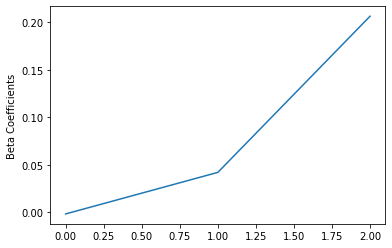

In [123]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(trained_sales_model.coefficients)
print(beta)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()